## Import

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import pathlib
from typing import Any,Union   

2022-10-03 09:09:47.587804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 09:09:47.968401: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 09:09:49.287302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-03 09:09:49.287393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
print(tf.config.experimental.list_physical_devices())
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


2022-10-03 09:09:51.486381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 09:09:51.559734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 09:09:51.560039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Def

In [3]:
BATCH_SIZE:int  = 64
IMG_HEIGHT:int  = 227
IMG_WIDTH:int   = 227

# Valdiate 20% 
VAL_SPLIT:float = 0.2

In [4]:
def get_dataset_dir(path) -> str:
    return pathlib.Path(path)

In [5]:
def load_dataset(dir) -> Union[list | Any, list | Any]:
  train_ds = tf.keras.utils.image_dataset_from_directory(
    dir,
    validation_split=VAL_SPLIT,
    label_mode='binary',
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)
  val_ds = tf.keras.utils.image_dataset_from_directory(
    dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    label_mode='binary',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)
  return train_ds, val_ds

## Load Dataset

In [6]:
data_dir:str = get_dataset_dir('data_binary/giga_data/')

train_ds, val_ds = load_dataset(data_dir)
class_names = train_ds.class_names

Nombres d'image: 35702
Found 36404 files belonging to 2 classes.
Using 29124 files for training.


2022-10-03 09:09:53.860685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 09:09:53.861729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 09:09:53.861977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 09:09:53.862538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Found 36404 files belonging to 2 classes.
Using 7280 files for validation.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

# Load datasets in cache to optimize 
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model

In [8]:
EPOCHS=15

In [9]:
with tf.device('/GPU:0'):
    # Def model
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),

        # tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
        # tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1),

        # Feature extraction
        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        # Deep NN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(256, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(64, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Compile model
    model.compile(optimizer='adamax', # or adam
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    # model.summary()

## Train

In [10]:
with tf.device('/GPU:0'):
    history:tf.keras.callbacks.History = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS
    )

Epoch 1/15


2022-10-03 09:10:01.219877: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-10-03 09:10:02.119296: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


456/456 [==============================] - 82s 167ms/step - loss: 0.3975 - accuracy: 0.7865 - val_loss: 0.3314 - val_accuracy: 0.8235
Epoch 2/15
456/456 [==============================] - 58s 127ms/step - loss: 0.3143 - accuracy: 0.8446 - val_loss: 0.2777 - val_accuracy: 0.8685
Epoch 3/15
456/456 [==============================] - 58s 128ms/step - loss: 0.2770 - accuracy: 0.8737 - val_loss: 0.2392 - val_accuracy: 0.8940
Epoch 4/15
456/456 [==============================] - 58s 128ms/step - loss: 0.2457 - accuracy: 0.8933 - val_loss: 0.2199 - val_accuracy: 0.9052
Epoch 5/15
456/456 [==============================] - 58s 128ms/step - loss: 0.2191 - accuracy: 0.9071 - val_loss: 0.2012 - val_accuracy: 0.9177
Epoch 6/15
456/456 [==============================] - 58s 127ms/step - loss: 0.1943 - accuracy: 0.9211 - val_loss: 0.2067 - val_accuracy: 0.9146
Epoch 7/15
456/456 [==============================] - 59s 128ms/step - loss: 0.1769 - accuracy: 0.9287 - val_loss: 0.1907 - val_accuracy: 0.9

## Validate

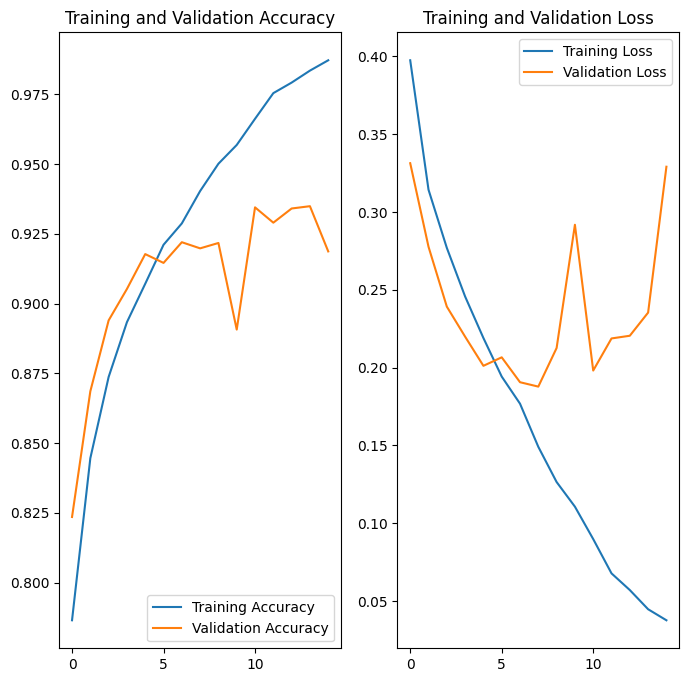

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save

In [12]:
import datetime
import pandas as pd

date:datetime = datetime.datetime.now().strftime("%m.%d.%Y_%H:%M:%S")
model_dir:str = f"models/binary_{date}"
model.save(model_dir)
f = open(f"{model_dir}/model_summary.txt", "a")
model.summary(print_fn=lambda x: f.write(x + '\n'))
f.close()

f = open(f"{model_dir}/model_history.csv", "a")
f.write(pd.DataFrame.from_dict(history.history).to_csv(index=False))
f.close()

INFO:tensorflow:Assets written to: models/binary_10.03.2022_09:24:57/assets


INFO:tensorflow:Assets written to: models/binary_10.03.2022_09:24:57/assets
